# WIT-WetMAP Analysis <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** WIT

## Description
This notebook analyses the observational results from the WetMAP Victoria waterbird surveys and compares them to WIT.

***

## Setup

In [6]:
pip install palettable

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import scipy.stats, scipy.odr
import palettable
import matplotlib.patches as mpat

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [8]:
dc = datacube.Datacube(app='WIT-WetMAP')

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


### Load WetMAP bird sites

This is a table in the appendix of the WIT paper.

In [9]:
sites = pd.read_csv('wetmap_data/wit_bird_sites.csv').set_index('Code')

### Load hydrology data

Load the WetMAP observational data and the corresponding WIT data:

In [10]:
wit = pd.read_csv('wetmap_data/hydrology_data.csv')
wmap = pd.read_csv('wetmap_data/bird_data.csv')

In [11]:
len(wmap)

151

In [12]:
wit['ga_date'] = pd.to_datetime(wit['ga_date'])
wit = wit.sort_values(['birdsitecode', 'ga_date'])

In [13]:
wit_to_sites = {
 'HISW_EAST': 'HISW_E',
 'HISW_WEST': 'HISW_W',
 'LAMU_NORTH': 'LAMU_N',
 'LAMU_SOUTH': 'LAMU_S',
 'LAYA': 'LAYO',
 'MCSW': 'MASW',
 'RILA_EAST': 'RILA_E',
 'RILA_WEST': 'RILA_W',
 'WILO_BW': 'WILO_BS',
}

In [14]:
def replace_birdsitecode(code):
    return wit_to_sites.get(code, code)
wit['birdsitecode'] = wit['birdsitecode'].apply(replace_birdsitecode)
wmap['birdsitecode'] = wmap['birdsitecode'].apply(replace_birdsitecode)

In [15]:
sites

,Name,Dominant vegetation type,Water regime
Code,,,
VINI,Vinifera Floodplain,Woodland,Periodically Inundated - Episodic
CARA,Carapugna,Woodland,Periodically Inundated - Seasonal
LAHE,Heywood's Lake,Open water,Periodically Inundated - Episodic
LLME,Little Lake Meran,Open water/aquatic macrophytes,Periodically Inundated - Episodic
ROLA,Round Lake,Open water,Permanent
LAME,Lake Meran,Open water,Permanent
LAMU_S,Lake Murphy South,Open water/aquatic macrophytes,Periodically Inundated - Episodic
LAMU_N,Lake Murphy North,Open water/aquatic macrophytes,Periodically Inundated - Episodic
LAEL,Lake Elizabeth,Open water,Permanent


Assign the number of pixels to each wetland for later noise level calculations.

In [16]:
wit['n_px'] = wit['area_ha_bird'] * 16

Set up the survey dates and group observations.

In [17]:
wmap['survey_date'] = pd.to_datetime(wmap['survey_date'])
wmap = wmap.sort_values(['birdsitecode', 'survey_date'])
wmap_grouped = dict(iter(wmap.groupby('birdsitecode')))

## Combine datasets

Linearly interpolate WIT to match the dates of WetMAP observations. Then combine WIT and WetMAP.

In [18]:
merged_dfs = []
for site, wit_ in wit.groupby('birdsitecode'):
    wmap_ = wmap_grouped[site]
    # WIT needs to be interpolated to match the dates of WetMAP observations.
    wmap_ = wmap_.set_index('survey_date')
    wit_ = wit_.set_index('ga_date')
    joint_index = wmap_.index.normalize().union(wit_.index.normalize())
    wit_ = wit_.reindex(joint_index).interpolate('time')
    # Then we can merge the datasets.
    merged = wmap_.join(wit_, how='left', rsuffix='_wit')
    del merged['birdsitecode_wit']
    merged_dfs.append(merged.reset_index().set_index(['birdsitecode', 'survey_date']))
merged_wit_wmap = pd.concat(merged_dfs)

In [19]:
merged_wit_wmap['wofs_ha'] = merged_wit_wmap['water'] / 100 * merged_wit_wmap['area_ha_bird']
merged_wit_wmap['tcw_ha'] = merged_wit_wmap['wet'] / 100 * merged_wit_wmap['area_ha_bird']

In [20]:
merged_wit_wmap = merged_wit_wmap.merge(sites, left_on='birdsitecode', right_index=True)

In [21]:
len(sites)

23

Drop sites with low-quality or low-count data.

In [22]:
sites.drop('MASW', inplace=True)
sites.drop('WILO_BS', inplace=True)
sites.drop('LAME', inplace=True)
sites.drop('NECC', inplace=True)

In [23]:
merged_wit_wmap.drop('MASW', inplace=True)
merged_wit_wmap.drop('WILO_BS', inplace=True)
merged_wit_wmap.drop('NECC', inplace=True)

## Making plots

This section makes all the plots.

### WIT water vs WetMap water

In [24]:
veg_types = {j: i for i, j in enumerate(sorted(set(merged_wit_wmap['Dominant vegetation type'])))}

In [25]:
cmap = np.array(palettable.cartocolors.qualitative.Safe_4.colors) / 255

Colours:

In [26]:
cmap[2] * 255, cmap[3] * 255

(array([221., 204., 119.]), array([ 17., 119.,  51.]))

In [27]:
veg_colours = {
     'Aquatic macrophytes': 'greenyellow',
     'Open water': 'dodgerblue',
     'Shrubland': cmap[2],
     'Woodland': cmap[3],
     'Emergent graminoids': 'yellowgreen',
}

veg_labels = {
     'Emergent graminoids': 'Emergent graminoids',
     'Emergent graminoids/aquatic macrophytes': 'Aquatic macrophytes',
     'Open water': 'Open water',
     'Open water/aquatic macrophytes': 'Aquatic macrophytes',
     'Open water/woodland fringe': 'Open water',
     'Shrubland': 'Shrubland',
     'Shrubland/emergent graminoids': 'Shrubland',
     'Shrubland/open water': 'Shrubland',
     'Woodland': 'Woodland',
}

In [28]:
merged_wit_wmap['n_px'] = merged_wit_wmap['area_ha_bird_wit'] * 16

[ 0.87555215 20.18585854]
water SpearmanrResult(correlation=0.6968176541338342, pvalue=8.344369625951853e-22)
water 0.7072450878620534
[0.93522594 9.48772832]
tot_water SpearmanrResult(correlation=0.7655313058415899, pvalue=2.1002889740994573e-28)
tot_water 0.7940492759463309


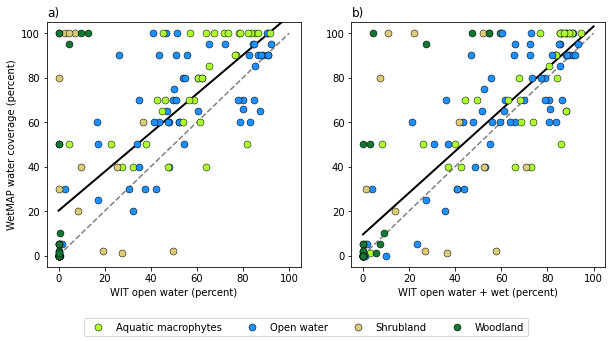

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
handles = {}
style = dict(
    markersize=7,
    marker='o',
    linestyle='None',
    linewidth=1,
    capsize=2,
    markeredgecolor='k', 
    markeredgewidth=0.5,
)
wetmap_err = 5
for veg_type, merged in merged_wit_wmap.groupby('Dominant vegetation type'):
    err = np.sqrt(merged['tot_water']) / merged['n_px'] * 100
    handle = axs[1].errorbar(merged.tot_water, merged.water_percent, label=veg_labels[veg_type], c=veg_colours[veg_labels[veg_type]],
                             **style)
#                              yerr=wetmap_err, xerr=err, **style)
    
#     for x, y, ex in zip(merged.tot_water, merged.water_percent, err):
#         el = mpat.Ellipse((x, y), ex * 2, wetmap_err * 2, alpha=0.2, facecolor=veg_colours[veg_labels[veg_type]])
#         axs[1].add_artist(el)

    err = np.sqrt(merged['water']) / merged['n_px'] * 100
    handle = axs[0].errorbar(merged.water, merged.water_percent, label=veg_labels[veg_type], c=veg_colours[veg_labels[veg_type]],
                             **style)
#                              yerr=wetmap_err, xerr=err, **style)
    handles[veg_labels[veg_type]] = handle

#     for x, y, ex in zip(merged.water, merged.water_percent, err):
#         el = mpat.Ellipse((x, y), ex * 2, wetmap_err * 2, alpha=0.2, facecolor=veg_colours[veg_labels[veg_type]])
#         axs[0].add_artist(el)

    
# Plot a trend line using ODR
def fit_function(params, x):
    return params[0] * x + params[1]

for ax, y in zip(axs, ['water', 'tot_water']):
    # Least squares regression
#     lr = scipy.stats.linregress(merged_wit_wmap.water_percent, merged_wit_wmap[y])
    # y = mx + b -> x = (y - b) / m
#     trend = (np.linspace(0, 100) - lr.intercept) / lr.slope
    lr = lr_ = scipy.odr.Model(fit_function)
    wit_err = 1 / (np.sqrt(np.where(merged_wit_wmap[y], merged_wit_wmap[y], 1)) / merged_wit_wmap['n_px'] * 100) ** 2
    dat = scipy.odr.Data(merged_wit_wmap[y], merged_wit_wmap.water_percent, wd=wit_err, we=1 / wetmap_err ** 2)
    odr = scipy.odr.ODR(dat, lr, beta0=[1, 0])
    out = odr.run()
    trend = fit_function(out.beta, np.linspace(0, 100))
    print(out.beta)
    
    mvals = out.beta[0] + np.linspace(-out.sd_beta[0], out.sd_beta[0], 21)
    bvals = out.beta[1] + np.linspace(-out.sd_beta[1], out.sd_beta[1], 21)
    mgrid, bgrid = np.meshgrid(mvals, bvals)
    fvals = []
    for m, b in zip(mgrid.ravel(), bgrid.ravel()):
        fvals.append(fit_function([m, b], np.linspace(0, 100)))
    trend_low = np.min(fvals, axis=0)
    trend_high = np.max(fvals, axis=0)
    ax.plot(np.linspace(0, 100), trend, c='k', linestyle='-', linewidth=2)
#     ax.fill_between(np.linspace(0, 100), trend_low, trend_high, fc='k', alpha=0.1)
    lr = scipy.stats.linregress(merged_wit_wmap[y], merged_wit_wmap.water_percent)
    print(y, scipy.stats.spearmanr(merged_wit_wmap[y], merged_wit_wmap.water_percent))
    print(y, lr.rvalue)
    
#     ax.plot([0, 100], [0, 100], linestyle='--', color='grey')
for ax in axs:
    # Shrink axis height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.10,
                     box.width, box.height * 0.90])
    # Plot a 1-1 line
    ax.plot([0, 100], [0, 100], linestyle='--', color='grey')
    # Limit the axes
    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)
axs[0].set_ylabel('WetMAP water coverage (percent)')
axs[1].set_xlabel('WIT open water + wet (percent)')
axs[0].set_xlabel('WIT open water (percent)')
axs[0].text(0, 1.01, 'a)', transform=axs[0].transAxes, va='bottom', fontdict={'size': 12})
axs[1].text(0, 1.01, 'b)', transform=axs[1].transAxes, va='bottom', fontdict={'size': 12})
# Put a legend below the figure

leg = fig.legend(map(handles.get, sorted(handles)), sorted(handles),
                 loc='lower center', ncol=4)
fig.savefig('wit_wetmap.png')
fig.savefig('wit_wetmap.pdf')

n points 141


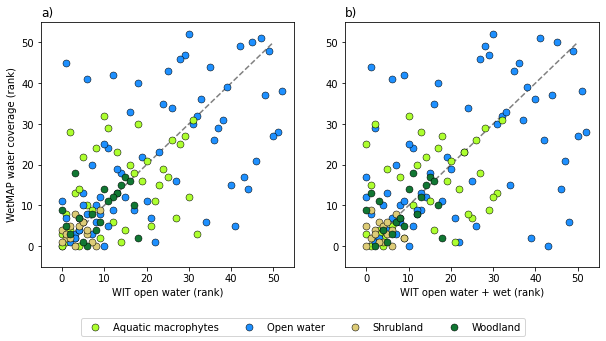

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
n_tot = 0
for veg_type, merged in merged_wit_wmap.groupby('Dominant vegetation type'):
    xs = merged.tot_water
    ys = merged.water_percent
    xs = np.argsort(xs)
    ys = np.argsort(ys)
    handle = axs[1].errorbar(xs, ys, label=veg_labels[veg_type], c=veg_colours[veg_labels[veg_type]],
                             **style)
    xs = merged.water
    xs = np.argsort(xs)
    handle = axs[0].errorbar(xs, ys, label=veg_labels[veg_type], c=veg_colours[veg_labels[veg_type]],
                             **style)
    handles[veg_labels[veg_type]] = handle
    n_tot += len(xs)
print('n points', n_tot)

for ax in axs:
    # Shrink axis height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.10,
                     box.width, box.height * 0.90])
    # Plot a 1-1 line
    ax.plot([0, 50], [0, 50], linestyle='--', color='grey')
    # Limit the axes
    ax.set_xlim(-5, 55)
    ax.set_ylim(-5, 55)
axs[0].set_ylabel('WetMAP water coverage (rank)')
axs[1].set_xlabel('WIT open water + wet (rank)')
axs[0].set_xlabel('WIT open water (rank)')
axs[0].text(0, 1.01, 'a)', transform=axs[0].transAxes, va='bottom', fontdict={'size': 12})
axs[1].text(0, 1.01, 'b)', transform=axs[1].transAxes, va='bottom', fontdict={'size': 12})
# Put a legend below the figure

leg = fig.legend(map(handles.get, sorted(handles)), sorted(handles),
                 loc='lower center', ncol=4)

## Hydrology plots

In [31]:
agg_veg_type = sites['Dominant vegetation type'].apply(veg_labels.get)

In [32]:
len(sites)

19

In [33]:
sites.set_index('Name')['Dominant vegetation type'].apply(veg_labels.get).sort_values()

Name
Moodie Swamp                Aquatic macrophytes
Little Lake Meran           Aquatic macrophytes
Lake Murphy South           Aquatic macrophytes
Lake Murphy North           Aquatic macrophytes
Reedy Swamp                          Open water
Heywood's Lake                       Open water
Round Lake                           Open water
Lake Elizabeth                       Open water
Lake Cullen                          Open water
Black Swamp                          Open water
Richardson's Lagoon West             Open water
Hird Swamp West                      Open water
Richardson's Lagoon East             Open water
Wirra-Lo Lignum Swamp                 Shrubland
Gaynor Swamp                          Shrubland
Hird Swamp East                       Shrubland
Lake Yando                             Woodland
Carapugna                              Woodland
Vinifera Floodplain                    Woodland
Name: Dominant vegetation type, dtype: object

/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


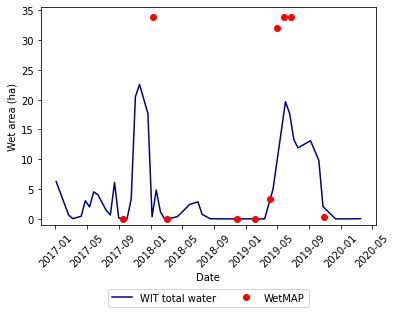

In [34]:
for site in agg_veg_type.sort_values().index:
    if site != 'VINI':
        continue
    fig, ax = plt.subplots()
    site_ts = wit[wit.birdsitecode == site]
    site_birds = wmap[wmap.birdsitecode == site]
#     err_water = np.sqrt(site_ts['water']) / site_ts['n_px'] * 100
    xs = pd.to_datetime(site_ts.ga_date)
#     plt.plot(xs, site_ts.water * site_ts.area_ha_bird / 100, label='Open water', c='teal')
#     plt.fill_between(xs, np.maximum(site_ts.water - err_water, 0), site_ts.water + err_water, fc='teal', alpha=0.5)
#     err_water = np.sqrt(site_ts['tot_water']) / site_ts['n_px'] * 100
    plt.plot(xs, (site_ts.water + site_ts.wet) * site_ts.area_ha_bird / 100, label='WIT total water', c='darkblue')
#     plt.fill_between(xs, np.maximum(site_ts.tot_water - err_water, 0), site_ts.tot_water + err_water, fc='darkblue', alpha=0.5)
    yerr = np.array([[v - max(v - wetmap_err, 0), wetmap_err] for v in site_birds.water_percent]) / 100 * site_birds.area_ha_bird[:, None]
    plt.errorbar(pd.to_datetime(site_birds.survey_date), site_birds.water_ha, c='red', linestyle='None', marker='o',
                 label='WetMAP')
#                  yerr=yerr.T)
    plt.ylim(-1)
    plt.ylabel('Wet area (ha)')
    plt.xlabel('Date')
    plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.4))
    plt.xticks(rotation=45)
#     plt.title(f'{site} ({agg_veg_type.loc[site]})')
    plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2021

**Compatible datacube version:** 

In [35]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2
